## P4DS (ODL1) Assignment 3

# Data Analysis Project

#### Notebook template design: Brandon Bennett (2020.11.03, revised 2021.03.02)

# _Chess opening selection based on players' age and location_


#### Student: Laszlo Kovari

#### Email: od20lk@leeds.ac.uk

# Project Plan

## The Data (10 marks)

To be able to analyse chess players' opening style change over time and to see if there are bigger differences between countries, multiple different data sources were included, modified, or even created. These are:

- **Game database**
    - The main body of the analysis, as it has to cover 30-40 years' of data to be meaningful for this task. There are several freely usable databases, the one called [Caissabase](http://caissabase.co.uk) with 4.2 million games was selected. Unfortunately even this database has very limited data from earlier than 2010. There are alternatives that were not usable for various reason. Chessbase is the largest professional one, commercial, not reusable and shareable, Millionbase is a part of the selected set, while [Lichess](https://lichess.org) and [FICS](http://www.freechess.org) are both free online chess servers that publish their game databases. However, as these are internet servers. acronyms and usernames are used and not suitable for this task
    - Essentially all these databases come in the so-called Portable Game Notation format, which is the standard textual representation of chess games ([PGN](https://en.wikipedia.org/wiki/Portable_Game_Notation)). The games database was converted to csv with only containing the header data and removing all moves.
- **Player database**
    - To be able to follow a person's chess history a comprehensive list of players is needed containing at least 30-40 years' of data. The international chess organisation [FIDE](www.fide.org) maintains this list, however, they did not keep this precise throughout the years. Fortunately Howard published an article [Howard, 2006](https://core.ac.uk/download/pdf/205518195.pdf) and he unselfishly made the database available on [Open Science Framework](https://osf.io/hyn2d/)
    - The database is in Microsoft Access format, so it was converted to csv for pandas to process it.
    - The used data lists from the database are:
        - players.csv - ID, name, date of birth
        - RatingsRanksTitlesearlier - ID, player country, rating information before 2016
        - RatingsRanksTitleslater - ID, player country, rating information after 2016
- **ECO code list and assessment**
    - The ECO code system is the de facto standard for chess opening classification and contains 1 character and 2 integers as key for each opening. As we'll see later in the limitations section this somewhat narrows down the possibilities. The list of ECO codes can be seen i.e. on [Wikipedia](https://en.wikipedia.org/wiki/Encyclopaedia_of_Chess_Openings)
    - While the opening names and codes are hence known, they give no implication how positional or sharp a given opening is, for that goal a custom mapping was created (based on expert knowledge, as no standard is available on this somewhat subjective topic). This is available with all the other [source files](https://drive.google.com/drive/folders/15wEVKEMiNeuZSfXBMS4B72IcLDnGU-np?usp=sharing)
    - For each opening variation the ECO code and 2 booleans and an include parameter are stored. The booleans denote whether the particular line is 'sharp' when played with white and when played with black. Sometimes it can be both, one of them or neither depending on the variation and the choices available. (so for instance black can play a sharp line in an otherwise dull opening). The include parameter is mainly added to exclude too broad 'catch-all' lines and oddities.
- **Country codes**
    - This seemed rather straightforward, however given the mix of standards and the low level of data quality in the players database, this also had to be amended. The current source is a mapping of country codes and names from the following sources:
        - players database
        - Alpha-3 codes (i.e. from [nationsonline.org](https://www.nationsonline.org/oneworld/country_code_list.htm) )
        - geopandas country names - as the players country codes are very mixed, names are used to display countries on the map where possible

   



## Project Aim and Objectives (5 marks)

This project spans from a personal experience and was chosen as a data analysis task for a personally interesting, though admittedly very niche topic. With age I have realised that from a very sharp (and theoretically decent) chess player I have become a more positional one. Due to lack of time to train and play I started choosing chess openings that require way less knowledge or learning and in general are less sharp. Coming from the Eastern Bloc it is also interesting to see if large 'schools of chess' have a significant effect on players' opening choices

- This project tries to answer two questions:
    - Is it a generic situation that chess players tend to pick up more solid lines as they age? 
    - Does the country of origin has a big effect on the player's chess opening choices?` 
    

### Specific Objective(s)


* __Objective 1:__ Show if in general chess players start playing more positional openings as they age by
    * classifying openings, creating an aggregated and age-grouped Dataframe of a huge number of publicly available games with assessment if those games' openings were sharp 
    * visualise change of sharp opening selection of players as they age


* __Objective 2:__ Show if there are geographical patterns whether a given country's chess players select sharp or positional openings more (i.e. 'Russian school of chess') by 
    * classifying countries based on their players' opening style
    * display countries' classifications on a world map 

## System Design (5 marks)


### Architecture

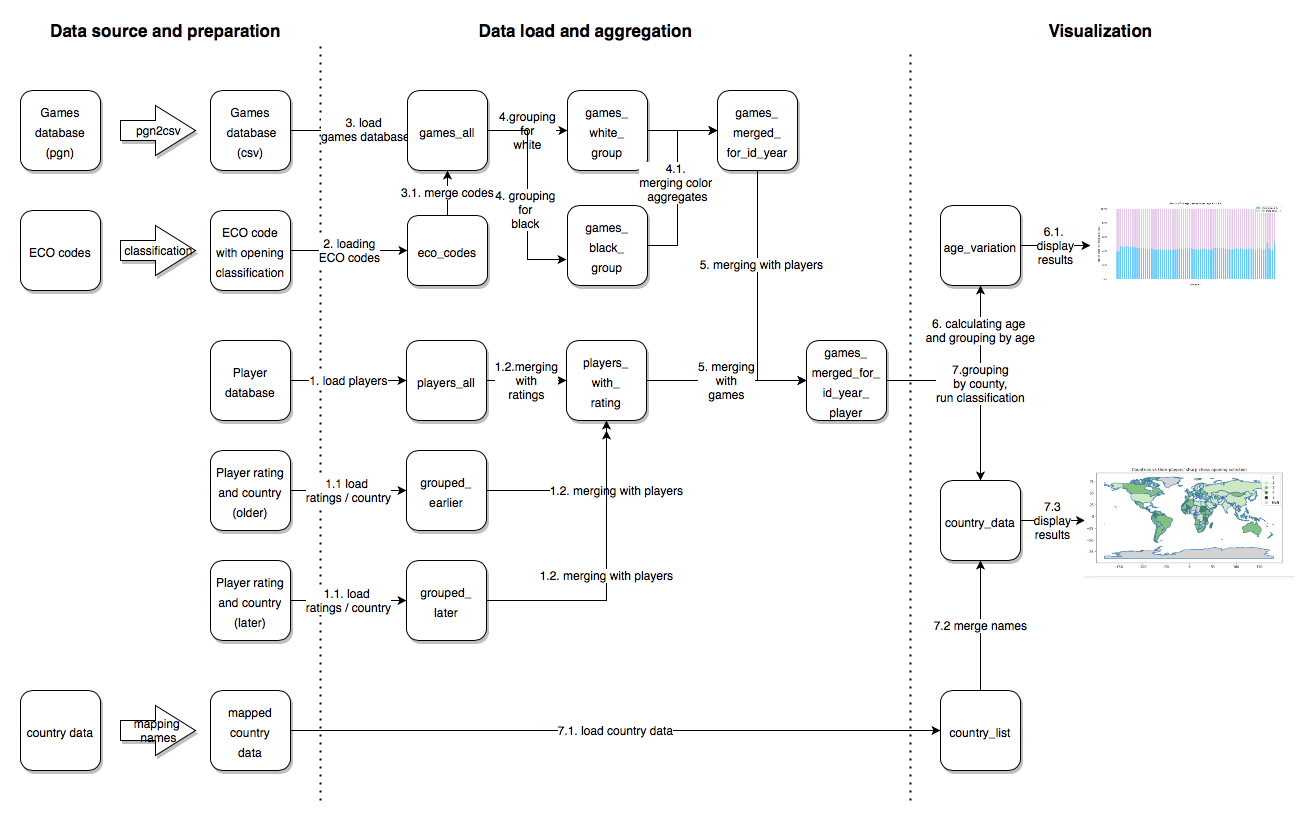

- The architecture of this project is rather straightforward, almost fully linear, the input files are read, merged to various interim dataframes, grouped by columns that are relevant for analysis and visualisation:
    - 0. Preparation - before the notebook
        - Games file is converted to csv containing header only
        - ECO codes are classified
    - 1. Loading players base and ratings data. These dataframes then are merged together to have a single players frame with all necessary details
    - 2. Loading ECO codes 
    - 3. Loading games database and merging with the ECO codes list
    - 4. The games data needs to be grouped for white and for black players, this will result in 2 large aggregated dataframes. This is then merged again so for each player ID there'll be a list of aggregated games' data 
    - 5. merging the output of step 4 (games frame) with the output 1 (players dataframe) so there is one single dataframe with all player and games details grouped by player ID
    - 6. to analyse age distribution output of step 5 is further modified and grouped by age yielding a dataframe where games' data are aggregated by the age of the player when the game was played. This data can then be visualised
    - 7. independent from step 6, the output step 5 is enhanced with loading and merging a country list, grouping by country and then displaying the results on a map

  
### Processing Modules and Algorithms

_Briefly list and describe the most significant computational components of your system and the algorithms you will use to implement them. 
This could include things like:_

* _cleaning the data by removing outliers_
* _combining different datasets_
* _converting samples to a special representaion (such as feature vectors)_
* _constructing a special data-structure (such as a decision tree)_
* _running some kind of analysis_

_Your list can be presented in similar form to the one just given, 
but should include a brief
but more specific description of the components and/or algorithms.
Probably three or four components is sufficient for most projects, but
you may want to have more._

The most significant processing modules or components are:
- conversion between different data formats:
    - converting games data from pgn format to csv (external python class)
    - The pgn2csv class is a simple queue-based converter that takes an input pgn file and outputs a csv file with the most necessary header information. Alternatives (i.e. pgn2data) were either too broad, were not working or took too long due to many other features. Pgn2csv is public on https://github.com/lacibacsi/chess_playing_style_analysis
    - This conversion is not run as part of the notebook as it both takes a few minutes as well as it can be considered data source building
- combining / merging different data set
    - as shown in the above diagram, the vast majority of the processing pipeline is to load data files and  merge them (players data, game with players data, eco codes with games, etc.). This happens between dataframes at various steps during the processing
- aggregating data sets
    - apart from merging data from different sources data is aggregated by using pandas.groupby. Depending on the case and grouping rules, specific apply functions were developed that select, convert or calculate new columns based on the original dataframe's columns
- cleaning data
    - cleaning of data happens at 2 different stages of the pipeline. Once, before the notebook can be run (i.e. country codes change, country name mapping) and once during processing. Columns with NaN or null values are either filled with default (i.e. 0) or those records are dropped (i.e. players with no country set for location analysis)
- outlier handling
    - outliers - similarly to data quality issues - were handled either by removing them from the visualisation or further processing them or left there and be displayed. 
        - examples for outlier removal is players age, where due to ID reuse (see [Howard, 2006](https://core.ac.uk/download/pdf/205518195.pdf) ) players age for a game could be -40. For practical reasons games where the players younger than 6 or older than 89 were filtered out by simple dataframe filtering
        -  country outliers were different, as it turned out that geopandas map does not contain data and details for some smaller countries (i.e. Guernsey, Jersey) and hence they don't get displayed. Removing these countries would, however, have significantly altered the outcome, hence they were left in there for data and chart display, but geopandas does not show them on the map
- classification of countries
    - this was done by using auto-calculated bins between minimum and maximum ratios for countries and using pandas' cut to automatically categorise countries



# Program Code (15 marks)

## Overview of code
The whole analysis, unfortunately, turned out to be way larger than originally assumed and code kept piling up. Some of it was externalised (pgn2csv), but the rest for i.e. dataframe loading, merging, sorting, aggregating etc. could not be moved out, hence they are present below, most probably exceeding the 500 lines limit. I also looked at cutting the scope of removing i.e. country analysis, but it would have only cut down code by 20-30 lines, it wouldn't have been worth it.

- The project uses the following external libraries
    - **pgn2csv** (implicit, not needed to download)
    - **geopandas** - can be installed via conda. [more details](https://geopandas.org)
    - **fsspec** and **s3fs**  - anaconda can install these and are needed for s3 access. Unfortunately google drive does not provide easy direct access to large files, s3 does, so for 2 large source files s3 storage was used


## Control parameters for the calculations
The below settings how players will be included or excluded based on their games history as well as what it the minumum number of games for a country to be used in the geographical analysis. It also contains the settings for running mode (use url or local files, save / load temporary calculations and whether to use test data instead of the large non-test files) 

In [1]:
minimum_years_seen = 1  #number of years a player has to have games for analysis
minimum_games = 10 #number of games a player has to have across all the years seen
minimum_games_country = 50 #number of games for a country to be displayed in the geographical analysis

#if set to true only samples will be loaded not the full datasets
testmode = False

#if set to true precalculated data will be loaded from the saved files
use_prepared_data = False

#if true, when not using generated data interim results will be saved
#please note, when doing precalculation data will only be saved locally the notebook won't post it back
save_prepared_data = False

# if true the files will be read / grabbed from the urls - second and third items in the file name lists
# otherwise local sources will be read - source files need to be in the same directory as the notebook
use_urls = True

## Constants, helpers and other functions
This section contains imports, the constants needed to run the notebook (i.e. file locations) and generic functions that are reused in multiple places 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# folders where source files and the precalculated ones are stored - to be able to manually check contents
url_source_files: 'https://drive.google.com/drive/folders/15wEVKEMiNeuZSfXBMS4B72IcLDnGU-np/'
url_precalced: 'https://drive.google.com/drive/folders/1RMeA5K3y5_QPG10UE3-CDM-lL8iSD3hG/'

#default directory. the environment has to have geopandas installed and configured
#given the kernel may run in a different environment, start i.e:
# jupyter notebook --notebook-dir=/Users/laszlokovari/Documents/personal/leeds/Programming/Assignments/ChessAnalysis/notebook/

#default file names and urls to load and save
#each filename contains 3 values: [local file name, url for full data, url for sample data]
players_fn = ['Players', 'https://drive.google.com/uc?id=1XryDU569ecgU0X573DivDpBJgUzABh3N','https://drive.google.com/uc?id=13qWhq0QfhxVWT3OWct8TK0NOmqwUZqlp']
ratings_early_fn = ['RatingsRanksTitlesearlier',
                    's3://chessanalysis/RatingsRanksTitlesearlier.csv',
                    'https://drive.google.com/uc?id=1eq0-ZH_l5MYGdpsgDKwS-OQQcHCiBvmh']

ratings_late_fn = ['Ratingsrankstitleslater',
                   's3://chessanalysis/Ratingsrankstitleslater.csv',
                   'https://drive.google.com/uc?id=1L29Q-Gcdl2bEnm-zX_Z4s-wfRrlJmZ3A']


eco_codes_fn = ['eco_codes','https://drive.google.com/uc?id=1v8STV2upc5GLp3jBI3mCR0tyHjaaTuPs','https://drive.google.com/uc?id=1JzAbo9vcda8PBMNJlxZi22_AHHEXTpyo']
#games csv file - assumes already converted data from pgn
games_fn = ['games',
            's3://chessanalysis/games.csv',
            'https://drive.google.com/uc?id=18bDYt6VWRrcQ06xJA_bUhGVezy57J7s9'] 
country_codes = ['countries_codes','https://drive.google.com/uc?id=1MLXgBnyamK64TRlM9eiwxou7Lc4KiVSe','https://drive.google.com/uc?id=1HRvSFlK2NbcQ5_pLydx9ivM0FDlD2MNy'] 
    
#file names for precalculated files
ratings_early_grouped_fn = ['ratings_early_grouped', 'https://drive.google.com/uc?id=10eyrCoG7HXEhuoZsipA4hoT8w5ilfnij','https://drive.google.com/uc?id=1YGj6_O6bUWUwef71PlMI6w3cwu_r_KQV']                            
ratings_later_grouped_fn = ['ratings_later_grouped', 'https://drive.google.com/uc?id=19rWxoXo3EZpa2mI21cGI_l4IM1Dfby06','https://drive.google.com/uc?id=1bwlf9L4WkTVCNTOKTcCRVlqyk18odbjk']                            
players_with_rating_fn = ['players_with_rating','https://drive.google.com/uc?id=1an1m6iRDyTZz_q0GKPeojDTXEAIMl-X4','https://drive.google.com/uc?id=146gmSIghbNNrLccjgyHPj5gvHKfnSoY4']
id_year_grouped_games = ['yearly_grouped_games_for_id','https://drive.google.com/uc?id=1pgArvy4RDCbTSIsGqsC-lh4__P2uR9kT','https://drive.google.com/uc?id=1uwdb6VIfeeQJoXHOfMjOInDQXkr9rzid']



In [3]:
def getfilename(fn, extension = 'csv'):
    """
        Returns the filename / url of the input filename list
        if url are used the second or third item of the relevant filename list is returned 
        for non-test / test respectively, 
        otherwise the first item (optionally with _sample added) and the extension is returned for local processing
    """
    if use_urls:
        if testmode:
            return fn[2]
        return fn[1]
    
    if testmode:
        fn = fn + '_sample'
    if extension == 'csv':
        fn = fn + '.csv'
    else:
        fn = fn + '.' + extension
    return fn

def savefile(filename, df):
    """
        Saves a files as UTF-8 encoded file
        
        Input:  filename, dataframe
        Output: none
    """
    
    df.to_csv(filename, sep=',', encoding = 'utf-8')
    
def loadfile(filename, separator = ','):
    """
        Loads a file and returns the dataframe read from it
        It assumes that the filename contains all the necessary details, i.e. url, token, querystring etc.
        
        Input:  filename
        Output: dataframe with the file contents
    """
    
    df = pd.read_csv(filename, sep=separator, encoding = 'utf-8')
    return df

## Dataframe functions
The below functions are used across multiple dataframes and include methods to add new columns, calculate columns during grouping. 

In [4]:
def add_totals(df):
    '''
        Calculates the total number of sharp and all games as well as the ratios
        
        Input:  Dataframe on which the operation needs to be done (pass by reference)
        Output: None
    '''
    df['total_sharp'] = df['sharp_white'] + df['sharp_black']
    df['total'] = df['total_white'] + df['total_black']
    df['sharp_ratio'] = round((df['total_sharp'] / df['total']).astype(float),2)
    df['not_sharp_ratio'] = (1-df['sharp_ratio']).astype(float)

# grouping functions to be used to aggregate game numbers. no year is seen
# the below 3 functions are used when grouping dataframes and the games numbers need to be summed
def grouping_base(x):
    d = {}
    d['sharp_white'] = x['sharp_white'].sum()
    d['total_white'] = x['total_white'].sum()    
    d['sharp_black'] = x['sharp_black'].sum()
    d['total_black'] = x['total_black'].sum()      
    return d
    
def game_grouping(x):
    d = grouping_base(x)      
    return pd.Series(d)

# grouping function with year
def game_grouping_with_year(x):    
    d = grouping_base(x)      
    d['years_seen'] = x['year'].count()
    return pd.Series(d)

#the below 2 functions are used when merging player colour-related data
def game_grouping_white(x):
    #grouping function for yearly game aggregation   
    d = {}
    d['sharp_white'] = x['Sharp_with_white'].sum()   #contains 1 or 0, sum will return the number of 1s
    d['total_white'] = x['Sharp_with_white'].count() #contains 1 or 0, count will return number of rows
    return pd.Series(d)

#grouping for white id & year and black id & year respectively
def game_grouping_black(x):
    #grouping function for yearly game aggregation
    d = {}
    d['sharp_black'] = x['Sharp_with_black'].sum()
    d['total_black'] = x['Sharp_with_black'].count()    
    return pd.Series(d)

def apply_grouping_rating(x, sequence = 1):
    """
        Grouping function for ratings aggregation 
        called when the dataframe is grouped by IDnumber, the player's id
        logic is based on the sequence, for white i.e. country1 for black country2 are the column names due to merge
        
        Input:  x: the dataframe row being read
                sequence: group white or black. 

        Output: None
    """
    
    #grouping by id, taking max rating, first seen, last seen
    columns = { 
        'country' : 'country', 
        'rating' : 'max_rating',
        'games' : 'games',
        'first_seen' : 'first_seen',
        'last_seen' : 'last_seen'}
    
    
    #add a trailing index to keys
    columns = {x: columns[x]+str(sequence) for x in columns }
    
    d = {}
    d[columns['country'] ] = x['Country'].max()
    d[columns['rating']] = x['Rating'].max()
    d[columns['games']] = x['Games'].sum()
    d[columns['first_seen']] = x['RatingDate'].min()
    d[columns['last_seen']] = x['RatingDate'].max()
    return pd.Series(d)

In [5]:
#Player and rating consolidation functions
#given the merge ends up having potentially 2 values for a player's country, rating, etc they need to be consolidates

def consolidate_player_country(row):
    if not pd.isna(row['country1']):
        return row['country1']
    else:
        return row['country2']

def consolidate_player_rating(row):
    if not pd.isna(row['max_rating1']):
        if pd.isna(row['max_rating2']) or row['max_rating1'] > row['max_rating2']:
            return row['max_rating1']
        
    return row['max_rating2']

def consolidate_player_games(row):
    if not pd.isna(row['games1']):
        if pd.isna(row['games2']) or row['games1'] > row['games2']:
            return row['games1']
    return row['games2']
    
def consolidate_player_first_seen(row):
    if not pd.isna(row['first_seen1']):
        if pd.isna(row['first_seen2']) or row['first_seen1'] < row['first_seen2']:
            return row['first_seen1']
    return row['first_seen2']

def consolidate_player_last_seen(row):
    if not pd.isna(row['last_seen1']):
        if pd.isna(row['last_seen2']) or row['last_seen1'] > row['last_seen2']:
            return row['last_seen1']
    return row['last_seen2']

## Chart functions
This section contains the chart generation and display functions as there are many parameters and this keeps the notebook somewhat less cluttered. 

In [6]:
def percent_format_func(value, tick_number):
    """
        Function to format a float to percent display along the chart axis
        
        Input:  value, tick_number from chart
        Output: float converted to percent, i.e. 0.43 -> 43%
    """    
    return str(int(value * 100))+' %'

# displaying on stack column charts
# one for the ratio of sharp games vs time, the other for the number of games and their sharp ratio over time
def display_age_group_charts():
    source = age_variation[['age_at_game','sharp_ratio','not_sharp_ratio','total_sharp','total' ]].sort_values('age_at_game')
    years = source['age_at_game']
    sharp = source['sharp_ratio']
    not_sharp = source['not_sharp_ratio']

    total_sharp = source['total_sharp']
    total = source['total'] # - source['total_sharp']

    bar_width = 0.6
    fig, axs = plt.subplots(2, 1, figsize=(16,16), sharex=True)
    axs[0].bar(years, sharp, bar_width, label = "Sharp games' %", color='deepskyblue', alpha=0.8)
    axs[0].bar(years, not_sharp, bar_width,bottom=sharp, label = "Not sharp games' %", color='plum', alpha=0.6)
    axs[0].legend(frameon=True)
    axs[0].set_xlabel('age (years)')
    axs[0].set_ylabel('ratio of sharp / not sharp games (%)')
    axs[0].yaxis.set_major_formatter(plt.FuncFormatter(percent_format_func))
    axs[0].grid(axis='y', linestyle='dotted', linewidth = 0.4)
    axs[0].use_sticky_edges = False
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['left'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['bottom'].set_visible(False)
    axs[0].tick_params(bottom=False, left=False)
    axs[0].set_title('Ratio of sharp games from age {} to {}'.format(years.min(), years.max()), pad=5, color='#333333',
                 weight='bold')

    axs[1].bar(years, total_sharp, bar_width/2, label = "Sharp games", color='deepskyblue', alpha=0.8)
    axs[1].bar(years, total, bar_width,bottom=0, label = "Total games", color='plum', alpha=0.6)
    axs[1].legend(frameon=True)
    axs[1].set_xlabel('age (years)')
    axs[1].set_ylabel('number of games')
    axs[1].grid(axis='y', linestyle='dotted', linewidth = 0.4)
    axs[1].use_sticky_edges = False
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['left'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['bottom'].set_visible(False)
    axs[1].tick_params(bottom=False, left=False)
    axs[1].set_title('Number of games from age {} to {}'.format(years.min(), years.max()), pad=5, color='#333333',
                 weight='bold')
    
def display_top_countries_chart():
    #displaying the 10-15 countries with the sharpest style... and the top 10-15 least sharp

    country_top = country_data[['sharp_ratio','name']].sort_values('sharp_ratio',ascending = False).head(10)
    fig, axs = plt.subplots(2, 1, figsize=(8,12), sharex=True)
    axs[0].barh(country_top['name'], country_top['sharp_ratio'],0.8,  label = "Sharp games' %", color='deepskyblue', alpha=0.8)
    axs[0].invert_yaxis()
    axs[0].xaxis.set_major_formatter(plt.FuncFormatter(percent_format_func))
    axs[0].set_xlabel("Percentage of sharp games", labelpad=10, weight='bold', size=8)
    axs[0].grid(axis='x', linestyle='dotted', linewidth = 0.4)
    axs[0].use_sticky_edges = False
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['left'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['bottom'].set_visible(False)
    axs[0].set_title('Countries playing the sharpest openings', pad=2, color='#333333',weight='bold')
    axs[0].tick_params(axis="x", which="major", bottom="off", top="off", labelbottom="on", left="off", right="on", labelleft="on")


    country_bottom = country_data[['sharp_ratio','name']].sort_values('sharp_ratio').head(10)
    axs[1].barh(country_bottom['name'], country_bottom['sharp_ratio'],0.8,  label = "Sharp games' %", color='plum', alpha=0.8)
    axs[1].invert_yaxis()
    axs[1].xaxis.set_major_formatter(plt.FuncFormatter(percent_format_func))
    axs[1].set_xlabel("Percentage of sharp games", labelpad=10, weight='bold', size=8)
    axs[1].grid(axis='x', linestyle='dotted', linewidth = 0.4)
    axs[1].use_sticky_edges = False
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['left'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['bottom'].set_visible(False)
    axs[1].set_title('Countries playing the least sharp openings', pad=2, color='#333333',weight='bold')
    axs[1].tick_params(axis="x", which="major", bottom="off", top="off", labelbottom="on", left="off", right="on", labelleft="on")

def display_countries_classification():
    #dispalying country categories on map    
    df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = df_world['geometry'].boundary.plot(figsize=(10,6))
    df_world_countries = df_world.merge(country_data, how='left', left_on='name', right_on='Map_country' )
    df_world_countries.plot( column='category', ax=ax, cmap='Greens', 
                         legend=True, missing_kwds={'color': 'lightgrey'})
    ax.set_title('Countries vs their players\' sharp chess opening selection')

## Data loading functions 
The below functions are used for loading source data. As part of the source data loading some data cleaning and formatting is also performed

In [7]:
def load_players():
    """
        Loads the list of chess players from the iput file
        renames id to match with the id of other files
        Cleans some data (i.e. fills empty date of birth) and calculates year born
        
        
        Input:   none
        Oiutput: dataframe of all players
    """
    fn = getfilename(players_fn)
    players_all = loadfile(fn,';')     
            
    #renaming IDNumber to IDnumber to be able to join on it later
    players_all.rename(columns={'IDNumber':'IDnumber'}, inplace = True)
    
    #cleaning some data, i.e. date of birth and calculating age
    #players w/o date of birth -> setting it to 0, so it can be used in non-age related, i.e. geographic analysis
    players_all['DOB'].fillna('0000', inplace= True)
    players_all['year_born'] = players_all['DOB'].str[0:4]
    players_all.sort_values('year_born', ascending = False)
    
    return players_all

def load_rating_list(data_type):
    
    """
        Loads the rating list for players, cleans (changed decimal to be correct) and formats column types
        Among others these files contains country information, hence will be used in geographical analysis 
        Contains rating which enables further filtering if needed        
        
        Input:  data_type indicating whether early or later data needs to be loaded. 
                accepted values: 'early' 'later'
        Output: dataframe with all ratings in useable format
    """
    if data_type == 'early':
        fn = getfilename(ratings_early_fn)              
    if data_type == 'later':
        fn = getfilename(ratings_late_fn)
        
    #loads the input file, replaces decimal 'point' and returns the dataframe
    dtypes = {'IDnumber': 'str', 'Title': 'str', 'WomensTitle':'str', 'Country':'str', 'Rating':'str', 'Games':'str', 'RatingDate': 'str' }
    df = pd.read_csv(fn, sep=';',dtype=dtypes)
    
    #replacing comma with decimal
    df['Rating'] = df['Rating'].str.replace(',','.')
    df['Games'] = df['Games'].str.replace(',','.')

    #filling rating and games nan with 0s
    df['Rating'].fillna(0.00, inplace=True)
    df['Games'].fillna(0.00, inplace=True)
    
    #converting column types    
    df['IDnumber'] = df['IDnumber'].astype(float)
    df['IDnumber'] = df['IDnumber'].astype(int)
    df['Rating'] = df['Rating'].astype(float)
    df['Games'] = df['Games'].astype(float)    
    
    return df

def load_eco_codes():    
    """
        Loads the eco codes for opening analysis. 
        The code list contains the assessment if a given variation is considered 'sharp'
        Y/N values are converted to 1/0 to ease calculation
        
        Input:  none
        Output: dataframe with all eco codes and their assessments
    """
    fn = getfilename(eco_codes_fn)
    eco_codes = loadfile(fn) # pd.read_csv('eco_codes.csv')
    #changing sharp values to 1 / 0 for summation
    eco_codes.loc[eco_codes['Sharp_with_white'] == 'Y', 'Sharp_with_white'] = 1
    eco_codes.loc[eco_codes['Sharp_with_white'] == 'N', 'Sharp_with_white'] = 0
    eco_codes.loc[eco_codes['Sharp_with_black'] == 'Y', 'Sharp_with_black'] = 1
    eco_codes.loc[eco_codes['Sharp_with_black'] == 'N', 'Sharp_with_black'] = 0
    return eco_codes

def load_chess_games():
    """
        Loads the list of chess games, formats columns and fills na values
        Adds a new column 'year' based on the games' date (set to 0000) if unknown
        
        Input:  none
        Output: dataframe of the list of all chess games 
    """
    fn = getfilename(games_fn)
    games_all = loadfile(fn) # pd.read_csv(fn, sep=',', encoding="utf-8")
    
    games_all['ECO'] = games_all['ECO'].str[0:3]
    #filling na values for ids and converting to int so matching can be done
    games_all['WhiteFideId'].fillna(0.0, inplace=True)
    games_all['BlackFideId'].fillna(0.0, inplace=True)
    games_all['WhiteFideId'].replace(' ',0.0, inplace = True)
    games_all['BlackFideId'].replace(' ',0.0, inplace = True)
    games_all['WhiteFideId'] = games_all['WhiteFideId'].astype(float)
    games_all['WhiteFideId'] = games_all['WhiteFideId'].astype(int)
    games_all['BlackFideId'] = games_all['BlackFideId'].astype(float)
    games_all['BlackFideId'] = games_all['BlackFideId'].astype(int)
    
    #adding year and merging with eco codes
    games_all['Date'].fillna(0, inplace=True)
    games_all['year'] = games_all['Date'].str[0:4]
    
    return games_all

def load_country_list():    
    """
        Loads the list of countries with name and codes. 
        Names are important as geopanda uses names or codes to display data for countries
        however, chess games seem to be having a mix of different country code standards (NOC, IOC, ISO)    
        so the chart uses name 
        
        Input:  none
        Output: dataframe of the list of countries
    """
    fn = getfilename(country_codes)
    country_list = loadfile(fn)

    country_list = country_list[['Country','IOC','Map_country']]
    country_list.rename(columns={'Country':'name', 'IOC':'country'}, inplace = True)

    return country_list

## Step 1 - Loading player and rating data
loading 3 files:
- Players.csv
- RatingsRanksTitlesearlier.csv
- RatingsRanksTitleslater.csv

building up a single dataframe with:
- player name
- date of birth if known
- year of first seen
- year last seen
- maximum rating over the whole period

Given that the 2 ratings files are huge, an aggregated interim version will be saved if asked (parameter save_prepared_data).
Files are gouped by ID

In [8]:
players_all = load_players()
print(display(players_all.head(15)))

#displaying the current world champion to showcase
print(display(players_all[ (players_all['LastName'] == 'Carlsen') & (players_all['FirstName'] == 'Magnus') ]))
      

,IDnumber,LastName,FirstName,Sex,DOB,Firstonlist,year_born
0,14400316,Bogdanovic,Rajko,M,1931.11.15 0:00:00,1970.12.31 0:00:00,1931
1,4602757,Kiffmeyer,Constanz,M,1951.2.27 0:00:00,1970.12.31 0:00:00,1951
2,14400057,Kurajica,Bojan,M,1947.11.15 0:00:00,1970.12.31 0:00:00,1947
3,14500477777,Minic,Dragoljub,M,1937.3.5 0:00:00,1970.12.31 0:00:00,1937
4,14500159,Marangunic,Srdjan,M,1943.10.31 0:00:00,1970.12.31 0:00:00,1943
5,14500183,Marovic,Drazen,M,1938.1.14 0:00:00,1970.12.31 0:00:00,1938
6,14500078,Kovacevic,Vlatko,M,1942.3.26 0:00:00,1970.12.31 0:00:00,1942
7,14500264,Antunac,Goran,M,1945.4.16 0:00:00,1970.12.31 0:00:00,1945
8,14600030,Bukic,Enver,M,1937.12.2 0:00:00,1970.12.31 0:00:00,1937
9,14500280,Bukal,Vladimir,M,1939.11.1 0:00:00,1970.12.31 0:00:00,1939


None


,IDnumber,LastName,FirstName,Sex,DOB,Firstonlist,year_born
39568,1503014,Carlsen,Magnus,M,1990.11.30 0:00:00,2001.4.1 0:00:00,1990


None


The above cell loads the full player list and for test it shows the first 15 rows and the current world champion

### 1.1. Loading player rating and country information
The next 2 functions load player country and rating informatio. These lists contain 14.2 millions ratings data each as a person appears or can appear on every single quartely or yearly list as long as he or she is active

Converting these huge lists to a more manageable size, where each person (ID) has only one row by grouping them

In [9]:
if use_prepared_data:
    #load data from file
    fn = getfilename(ratings_early_grouped_fn)
    grouped_earlier = loadfile(fn)
    
    fn = getfilename(ratings_later_grouped_fn)
    grouped_later = loadfile(fn)
    
else:
    ratings_earlier = load_rating_list('early')
    #print(ratings_earlier['Rating'].sum()) #test ratings are read as numbers
    #grouping by ID and aggregating other data points
    grouped_earlier = ratings_earlier.groupby(['IDnumber'], sort=False).apply(apply_grouping_rating)

    ratings_later = load_rating_list('later')
    grouped_later = ratings_later.groupby(['IDnumber'], sort=False).apply(apply_grouping_rating,2)
    
#if set, saving the file for later reload, so may not need to regroup again
if save_prepared_data == True:
    fn = getfilename(ratings_early_grouped_fn)
    savefile(fn, grouped_earlier)
    
    fn = getfilename(ratings_later_grouped_fn)
    savefile(fn, grouped_later)

print('first rating list: ')
print(display(grouped_earlier.head()))

print('second rating list: ')
print(display(grouped_later.head()))



/var/folders/1x/zcg8y_kn483f7n01d887r4t80000gp/T/ipykernel_86137/365188459.py:10: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  ratings_earlier = load_rating_list('early')
/var/folders/1x/zcg8y_kn483f7n01d887r4t80000gp/T/ipykernel_86137/365188459.py:15: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  ratings_later = load_rating_list('later')


first rating list: 


,country1,max_rating1,games1,first_seen1,last_seen1
IDnumber,,,,,
45094586,IND,1292.0,14.0,2015.10.1 0:00:00,2016.7.1 0:00:00
12524670,IRI,2053.0,106.0,2011.11.1 0:00:00,2016.7.1 0:00:00
25646672,IND,1134.0,5.0,2016.2.1 0:00:00,2016.7.1 0:00:00
46616845,IND,1325.0,15.0,2013.10.1 0:00:00,2016.7.1 0:00:00
35071971,IND,1568.0,37.0,2014.10.1 0:00:00,2016.7.1 0:00:00


None
second rating list: 


,country2,max_rating2,games2,first_seen2,last_seen2
IDnumber,,,,,
1701150,SWE,2142.0,122.0,2016.10.1 0:00:00,2019.9.1 0:00:00
2039931,USA,2135.0,0.0,2016.10.1 0:00:00,2019.9.1 0:00:00
2803399,ISR,2148.0,6.0,2016.10.1 0:00:00,2019.9.1 0:00:00
103306,ARG,2135.0,0.0,2016.10.1 0:00:00,2019.9.1 0:00:00
895415,ITA,2317.0,371.0,2016.10.1 0:00:00,2019.9.1 0:00:00


None


The above cell loads both rating lists and as it can be seen it contains the country details for the players

### 1.2 Merging player data with ratings
combinig the player database can be essentially used for rating filtering and country mapping, i.e used in geographical display and filtering

The below prepares the consolidated player list with a single maximum rating and seen dates taking the min of first seen dates, the max of last seen dates and the max of ratings. There is no check on the country data, if the first is set then it's taken, if not, then the second, regardless of value

In [10]:
grouped_earlier = grouped_earlier.reset_index()
grouped_earlier['IDnumber'] = grouped_earlier['IDnumber'].astype(int)
grouped_later = grouped_later.reset_index()
grouped_later['IDnumber'] = grouped_later['IDnumber'].astype(int)

#using another checkpoint and stored file if set
if use_prepared_data:
    fn = getfilename(players_with_rating_fn)    
    players_with_rating = loadfile(fn)
else:
    players_with_rating = players_all.merge(grouped_earlier, on='IDnumber', how='left')
    players_with_rating = players_with_rating.merge(grouped_later, on='IDnumber', how='left')
    players_with_rating['country'] = players_with_rating.apply(consolidate_player_country, axis=1)
    players_with_rating['max_rating'] = players_with_rating.apply(consolidate_player_rating, axis=1)
    players_with_rating['games'] = players_with_rating.apply(consolidate_player_games, axis=1)
    players_with_rating['first_seen'] = players_with_rating.apply(consolidate_player_first_seen, axis=1)
    players_with_rating['last_seen'] = players_with_rating.apply(consolidate_player_last_seen, axis=1)
    #dropping old colums
    players_with_rating.drop(columns = ['country1', 'country2', 'max_rating1', 'max_rating2', 'games1', 'games2', 'first_seen1', 'first_seen2', 'last_seen1', 'last_seen2'], inplace = True )    

#if set, saving the consolidated player list
if save_prepared_data == True:
    fn = getfilename(players_with_rating_fn)
    savefile(fn,players_with_rating)

players_with_rating.head()

,IDnumber,LastName,FirstName,Sex,DOB,Firstonlist,year_born,country,max_rating,games,first_seen,last_seen
0,14400316,Bogdanovic,Rajko,M,1931.11.15 0:00:00,1970.12.31 0:00:00,1931,YUG,2435.0,129.0,1970.12.31 0:00:00,2019.9.1 0:00:00
1,4602757,Kiffmeyer,Constanz,M,1951.2.27 0:00:00,1970.12.31 0:00:00,1951,GER,2340.0,4.0,1970.12.31 0:00:00,2019.9.1 0:00:00
2,14400057,Kurajica,Bojan,M,1947.11.15 0:00:00,1970.12.31 0:00:00,1947,YUG,2595.0,2049.0,1970.12.31 0:00:00,2019.9.1 0:00:00
3,14500477777,Minic,Dragoljub,M,1937.3.5 0:00:00,1970.12.31 0:00:00,1937,YUG,2490.0,142.0,1970.12.31 0:00:00,2006.1.1 0:00:00
4,14500159,Marangunic,Srdjan,M,1943.10.31 0:00:00,1970.12.31 0:00:00,1943,YUG,2495.0,505.0,1970.12.31 0:00:00,2019.9.1 0:00:00


## 2. Loading ECO codes
ECO classification file is simple table for opening variants denoted by the 3 letter ECO codes. For each such code some assessment has been made to see if it is 'sharp' when played by white and by black. This is a simple source loading 

In [11]:
eco_codes = load_eco_codes()
eco_codes

,ECO,In_analysis,Short_name,Sharp_with_white,Sharp_with_black,comment
0,A00,N,"Oddities (Sokolsky, Grab etc.)",0,0,NaN
1,A01,Y,Larsen,1,0,NaN
2,A02,Y,Bird's opening / From (f4 e5),1,1,NaN
3,A03,Y,Bird's opening /(f4 d5),1,0,NaN
4,A04,Y,Reti,0,0,NaN
...,...,...,...,...,...,...
494,E95,Y,King's Indian,1,1,NaN
495,E96,Y,King's Indian,1,1,NaN
496,E97,Y,King's Indian,1,1,NaN
497,E98,Y,King's Indian,1,1,NaN


It is important to note that the some openings are sharp only for one of the colours (i.e. Larsen in the above list or can be excluded, i.e. A00 

## 3. Loading chess games file
The below loads the full games files and merges it with the previously loaded eco list. For every game the following will be used:
- player ids
- colour - if played with white or black
- year or date of the game
- ECO code or classification. This will be used to classify games to be sharp or not sharp

In [12]:
games_all = load_chess_games()
games_all =  games_all.merge(eco_codes, on='ECO', how='left')
#filtering out variations not in analysis
games_all = games_all[games_all['In_analysis']=='Y']
print('games loaded,  number of games: '+str(games_all.shape[0]))
games_all.head(10)

/var/folders/1x/zcg8y_kn483f7n01d887r4t80000gp/T/ipykernel_86137/1978074359.py:88: DtypeWarning: Columns (7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  games_all = loadfile(fn) # pd.read_csv(fn, sep=',', encoding="utf-8")


games loaded,  number of games: 4195063


,Date,White,Black,Result,BlackElo,WhiteElo,ECO,Opening,Variation,WhiteFideId,BlackFideId,year,In_analysis,Short_name,Sharp_with_white,Sharp_with_black,comment
0,2018.10.08,"Markelova, L","Guseva, Marina",0-1,2409.0,2190.0,D12,QGD Slav,4.e3 Bf5,24131369,4149351,2018,Y,Queen's gambit,0,0,Slav
1,2018.10.08,"Ozgibcev, A","Shariyazdanov, A",1-0,2526.0,2368.0,B08,Pirc,"classical, h3 system",4139704,4122747,2018,Y,Pirc,1,1,NaN
2,2018.10.08,"Moiseenko, Va","Linker, M",1/2-1/2,2269.0,2492.0,A05,Reti opening,NaN,4123700,14101734,2018,Y,Reti,0,0,NaN
3,2018.10.08,"Tekeyev, Z","Nepomniachtchi, I",0-1,2759.0,2392.0,B51,Sicilian,"Canal-Sokolsky (Nimzovich-Rossolimo, Moscow) a...",4199731,4168119,2018,Y,Sicilian,1,1,NaN
4,2018.10.08,"Guseva, Marina","Drozdova, D",1/2-1/2,2183.0,2409.0,E21,Nimzo-Indian,three knights variation,4149351,4170695,2018,Y,Nimzo Indian,1,1,NaN
5,2018.10.08,"Peralta, Fe","Guerra Mendez, J",1/2-1/2,2534.0,2582.0,E43,Queen's Indian,4.Nc3,105309,3508129,2018,Y,Nimzo Indian,0,0,NaN
6,2018.10.08,"Tomilova, E","Sakorenko, Adriana",1-0,2061.0,2328.0,A14,English opening,Agincourt variation,4162340,34130249,2018,Y,English,0,0,NaN
7,2018.10.08,"Srijit, Paul","Satkar, Chirag",1-0,2089.0,2292.0,C55,Two knights defence (Modern bishop's opening),NaN,5094798,25010522,2018,Y,Two knights,1,1,"most of the white variations are sharp, can't ..."
8,2018.10.08,"Kurbedinov, R","Apryshko, G",1-0,2399.0,2305.0,A42,Reti opening,NaN,14200619,24131792,2018,Y,"Modern defence, Averbakh",0,1,NaN
9,2018.10.08,"Kiran, M","Rakesh, Kumar Jena",0-1,2388.0,2147.0,B06,Robatsch (modern) defence,NaN,5019575,5084822,2018,Y,Modern defence,1,1,NaN


## 4 & 5 Grouping game data for white and black and merging with players data
The same variation can be considered different depending on whether it's played by white or by black, so the merged game file needs to be grouped by player ID for both colours and then merged together for a player, but this time on the player level only (i.e. no individual game level information is retained) 

Once the game data aggregation is done the players dataframe (now containing ratings) can be merged with this again containing i.e. country details

In [13]:
games_white_group = games_all.groupby(['WhiteFideId','year'], sort=False).apply(game_grouping_white)
games_white_group.reset_index(inplace = True)
games_white_group.rename(columns={'WhiteFideId':'IDnumber'}, inplace = True)
print('aggregated list based on white')
print(display(games_white_group.head()))

games_black_group = games_all.groupby(['BlackFideId','year'], sort=False).apply(game_grouping_black)
games_black_group.reset_index(inplace = True)
games_black_group.rename(columns={'BlackFideId':'IDnumber'}, inplace = True)

print('aggregated list based on white')
print(display(games_black_group.head()))

aggregated list based on white


,IDnumber,year,sharp_white,total_white
0,24131369,2018,6,22
1,4139704,2018,4,22
2,4123700,2018,28,78
3,4199731,2018,15,28
4,4149351,2018,26,84


None
aggregated list based on white


,IDnumber,year,sharp_black,total_black
0,4149351,2018,24,79
1,4122747,2018,4,4
2,14101734,2018,12,16
3,4168119,2018,61,73
4,4170695,2018,12,43


None


In [14]:
# the final merged table contains aggregated data for analysis
# it contains grouped game summary for every year and for every player
# given the time it takes to generates, it can be pregen-ed and loaded as well
if use_prepared_data:
    fn = getfilename(id_year_grouped_games)
    games_merged_for_id_year_player = loadfile(fn)
else:
    #joining the 2 dataframes - outer join, there could be players with only one colour
    games_merged_for_id_year = games_white_group.merge(games_black_group, on=['IDnumber','year'], how='outer')
    #filtering players with no id
    games_merged_for_id_year= games_merged_for_id_year[games_merged_for_id_year['IDnumber'] != 0 ]

    #merging player data with aggregated games info. this will then be used to analyze age and country related data
    games_merged_for_id_year_player = games_merged_for_id_year.merge(players_with_rating, on='IDnumber', how='left')
    
    #filtering for unknown players
    games_merged_for_id_year_player = games_merged_for_id_year_player[games_merged_for_id_year_player['LastName'].notnull() ]

#saving temp file as the aggregation takes quite some time
if save_prepared_data:
    fn = getfilename(id_year_grouped_games)
    savefile(fn, games_merged_for_id_year_player)

print('final merged dataframe with games and players data too:')
games_merged_for_id_year_player.head()

final merged dataframe with games and players data too:


,IDnumber,year,sharp_white,total_white,sharp_black,total_black,LastName,FirstName,Sex,DOB,Firstonlist,year_born,country,max_rating,games,first_seen,last_seen
0,24131369,2018,6.0,22.0,1.0,26.0,Markelova,Lubov,F,1992.1.1 0:00:00,2006.10.1 0:00:00,1992,RUS,2200.0,384.0,2006.10.1 0:00:00,2019.9.1 0:00:00
1,4139704,2018,4.0,22.0,8.0,20.0,Ozgibcev,Anatoly,M,1960.7.25 0:00:00,1998.7.1 0:00:00,1960,RUS,2459.0,164.0,1998.7.1 0:00:00,2019.9.1 0:00:00
2,4123700,2018,28.0,78.0,41.0,77.0,Moiseenko,Vadim,M,1994.1.1 0:00:00,2007.10.1 0:00:00,1994,RUS,2567.0,357.0,2007.10.1 0:00:00,2019.9.1 0:00:00
3,4199731,2018,15.0,28.0,19.0,28.0,Tekeyev,Zaur,M,1995.1.1 0:00:00,2008.7.1 0:00:00,1995,RUS,2407.0,239.0,2008.10.1 0:00:00,2019.9.1 0:00:00
4,4149351,2018,26.0,84.0,24.0,79.0,Romanko,Marina,F,1986.8.5 0:00:00,1999.7.1 0:00:00,1986,RUS,2466.0,1069.0,1999.7.1 0:00:00,2019.9.1 0:00:00


## 6. Answering question 1 - calculating age and grouping by age
This next cell calculates the age when the games were played for each player / year, removes data where this cannot be set. Once done the data is filtered minimum games and years seen as set at the top of the code. 
can be used for age variation display. Once filtered the dataframe is grouped

In [15]:
#dropping unnecessary columns, filtering on having a year_born value, filling nan
#and calculating age at game for variation analysis
age_variation = games_merged_for_id_year_player[['IDnumber', 'year', 'sharp_white','total_white', 'sharp_black','total_black', 'year_born']]
age_variation = age_variation[ age_variation['year_born'] != '0000' ] 

age_variation['age_at_game'] = age_variation['year'].astype(int) - age_variation['year_born'].astype(int)
age_variation.fillna(0.0, inplace = True)
#filtering out players with not enough games or not seen for enough years
#this is done by aggregating games for idnumber and counting the years seen. 
#once this list is there we can join it back to the above table (inner), so only those ids remain 
#that meet the filtering criteria
included_players = age_variation.groupby(['IDnumber'], sort=False).apply(game_grouping_with_year)
included_players['total_games'] = included_players['total_white'] + included_players['total_black']
included_players = included_players[(included_players['years_seen'] >= minimum_years_seen) & (included_players['total_games'] >= minimum_games)]
included_players.reset_index(inplace = True)
#dropping unneeded columns, just need Id, then rejoin the table
included_players = included_players['IDnumber']
age_variation = age_variation.merge(included_players, on='IDnumber', how = 'inner')
age_variation.head()


,IDnumber,year,sharp_white,total_white,sharp_black,total_black,year_born,age_at_game
0,24131369,2018,6.0,22.0,1.0,26.0,1992,26
1,24131369,2017,3.0,12.0,2.0,10.0,1992,25
2,24131369,2016,8.0,40.0,9.0,38.0,1992,24
3,24131369,2015,4.0,7.0,1.0,7.0,1992,23
4,24131369,2014,1.0,3.0,4.0,5.0,1992,22


The above table now contains all the aggregated data for all games for all players that meet the original filtering criteria set at the top (number of years a player was seen and how many games minimum were played)

The only outstanding tasks are to clean up some outliers, where data is unlikely to be correct and to add totals and ratios. Games for age below 6 and above 89 are removed

In [16]:
#the dataframe still contains a lot of unneeded data for age variation (year, id, details year born)
#need to remove those and group / sum by age
#once grouped need to remove outliers, anything below the age of 6 and above age of 89 is to be removed
age_variation.drop(columns = ['IDnumber', 'year', 'year_born'], inplace = True )
age_variation = age_variation.groupby(['age_at_game'], sort=False).apply(game_grouping)
age_variation.reset_index(inplace = True)

#filtering outliers
age_variation = age_variation[ (age_variation['age_at_game'] >5) & (age_variation['age_at_game'] <90) ]

# add totals and ratios
age_variation.reset_index(inplace=True)
add_totals(age_variation)
age_variation['total_sharp'] = age_variation['sharp_white'] + age_variation['sharp_black']
age_variation['total'] = age_variation['total_white'] + age_variation['total_black']
age_variation['sharp_ratio'] = round((age_variation['total_sharp'] / age_variation['total']).astype(float),2)
age_variation['not_sharp_ratio'] = (1-age_variation['sharp_ratio']).astype(float)
age_variation.head()


,index,age_at_game,sharp_white,total_white,sharp_black,total_black,total_sharp,total,sharp_ratio,not_sharp_ratio
0,0,26,12617.0,32940.0,15192.0,32778.0,27809.0,65718.0,0.42,0.58
1,1,25,12502.0,32714.0,15237.0,32477.0,27739.0,65191.0,0.43,0.57
2,2,24,13421.0,34053.0,16259.0,33832.0,29680.0,67885.0,0.44,0.56
3,3,23,13558.0,34597.0,16370.0,34449.0,29928.0,69046.0,0.43,0.57
4,4,22,13719.0,35056.0,16136.0,34727.0,29855.0,69783.0,0.43,0.57


Run some analysis for people between age 18 and 23 and between 40 and 45 to compare their opening selection preferences

In [17]:
print('Ratio of sharp games for 18-23')
youngs = age_variation[ (age_variation['age_at_game'] >= 18) & (age_variation['age_at_game'] <= 23)] .sort_values('age_at_game')
youngs[['age_at_game','sharp_ratio', 'total']]


Ratio of sharp games for 18-23


,age_at_game,sharp_ratio,total
17,18,0.45,90939.0
16,19,0.44,84851.0
15,20,0.44,85009.0
14,21,0.43,73962.0
4,22,0.43,69783.0
3,23,0.43,69046.0


In [18]:
print('Ratio of sharp games for 40-45')
middleage = age_variation[ (age_variation['age_at_game'] >= 40) & (age_variation['age_at_game'] <= 45)] .sort_values('age_at_game')
middleage[['age_at_game','sharp_ratio','total']]

Ratio of sharp games for 40-45


,age_at_game,sharp_ratio,total
29,40,0.43,31041.0
30,41,0.42,32452.0
47,42,0.44,32799.0
39,43,0.43,29840.0
46,44,0.44,29526.0
45,45,0.44,29153.0


## 7. Answering question 2 - grouping data by country, classify countries
The below cell first takes the games dataframe merged with all player data grouped by player id and year and groups it by country. Once done totals are recalculated for countries and countries not meeting the minimum number of games are removed

In [19]:
# the dataframe for country comparisons will need to have the country column filled, 
# this will unfortunately seriously decrease the available data
# moreover for reasonable data it needs to be filtered for minimum games

country_data = games_merged_for_id_year_player[ games_merged_for_id_year_player['country'].notnull() ][['sharp_white', 'sharp_black', 'total_white', 'total_black','country']]
country_data = country_data.groupby(['country'], sort=False).apply(game_grouping)
add_totals(country_data)
country_data.reset_index(inplace = True)
country_data = country_data[country_data['total'] > minimum_games_country]
country_data

,country,sharp_white,total_white,sharp_black,total_black,total_sharp,total,sharp_ratio,not_sharp_ratio
0,RUS,47604.0,126682.0,58515.0,126134.0,106119.0,252816.0,0.42,0.58
1,ARG,7048.0,16428.0,8462.0,16341.0,15510.0,32769.0,0.47,0.53
2,IND,20711.0,54568.0,24478.0,54268.0,45189.0,108836.0,0.42,0.58
3,UZB,2567.0,6612.0,2919.0,6590.0,5486.0,13202.0,0.42,0.58
4,URS,11298.0,35271.0,16863.0,34972.0,28161.0,70243.0,0.40,0.60
...,...,...,...,...,...,...,...,...,...
190,SGP,63.0,115.0,64.0,118.0,127.0,233.0,0.55,0.45
191,LAO,27.0,63.0,26.0,67.0,53.0,130.0,0.41,0.59
192,PAK,70.0,239.0,104.0,241.0,174.0,480.0,0.36,0.64
193,LBN,79.0,179.0,92.0,185.0,171.0,364.0,0.47,0.53


The above dataframe's sharp_ratio column will be the base for classification and geographical display 

The below cell categorises countries based on the 'sharp_ratio' column value. The binning is done based on the difference between the minimum and maximum values of all country data. The higher the category value the higher the correspoding sharp_ratio is (the more sharp openings a given country's players play)

In [20]:
#each country is classified into one of 5 bands based equal distribution of min / max of country values
max_sharpness = country_data['sharp_ratio'].max()
min_sharpness = country_data['sharp_ratio'].min()
print('ranges is: {} to {}'.format(str(min_sharpness), str(max_sharpness)))

if max_sharpness > min_sharpness:
    #creating five bins dynamically and bin the countries based on these 
    bin_labels = [1,2,3,4,5]
    bin_size = (max_sharpness - min_sharpness) / 5

    bins = []
    for i in range(6):
        bins.append( round(min_sharpness + i*bin_size,2) )

    print('bin size' + str(bin_size))
    print(bins)
    
    #classify - bin countries
    country_data['category'] = pd.cut(country_data['sharp_ratio'], bins = bins, labels = bin_labels )    
else:
    country_data['category'] = 3
    print('cannot classify, not large enough range, setting all countries to 3')

#displaying data - contains bin / category as well now
country_data.head()

ranges is: 0.32 to 0.59
bin size0.05399999999999999
[0.32, 0.37, 0.43, 0.48, 0.54, 0.59]


,country,sharp_white,total_white,sharp_black,total_black,total_sharp,total,sharp_ratio,not_sharp_ratio,category
0,RUS,47604.0,126682.0,58515.0,126134.0,106119.0,252816.0,0.42,0.58,2
1,ARG,7048.0,16428.0,8462.0,16341.0,15510.0,32769.0,0.47,0.53,3
2,IND,20711.0,54568.0,24478.0,54268.0,45189.0,108836.0,0.42,0.58,2
3,UZB,2567.0,6612.0,2919.0,6590.0,5486.0,13202.0,0.42,0.58,2
4,URS,11298.0,35271.0,16863.0,34972.0,28161.0,70243.0,0.40,0.60,2


### 7.1. & 7.2. loading and merging country list
The below loads the source file coutry list and left merges on the country data generated above

In [21]:
#loading country code list, removing unneeded columns and merge it based on country code / alpha 3 iso code
country_list = load_country_list()
country_data= country_data.merge(country_list, on='country', how='left')

Displaying the top 10 countries playing sharp openings

In [22]:
print('Top 10 countries with sharpest opening play ')
c = country_data.sort_values('sharp_ratio', ascending = False)
c = c[['country', 'total_sharp','total', 'sharp_ratio','name']]
c.head(10)

Top 10 countries with sharpest opening play 


,country,total_sharp,total,sharp_ratio,name
168,GCI,218.0,369.0,0.59,Guernsey
84,MYN,82.0,142.0,0.58,Myanmar
176,BDI,134.0,237.0,0.57,Burundi
130,ESA,599.0,1052.0,0.57,El Salvador
97,ANT,29.0,52.0,0.56,Antigua and Barbuda
185,SGP,127.0,233.0,0.55,Singapore
162,JCI,371.0,669.0,0.55,Jersey
120,LIE,259.0,481.0,0.54,Liechtenstein
151,JOR,932.0,1739.0,0.54,Jordan
155,OMA,317.0,598.0,0.53,Oman


Displaying the top 10 countries playing positional openings

In [23]:
print('Top 10 countries with most positional opening play ')
c.tail(10)

Top 10 countries with most positional opening play 


,country,total_sharp,total,sharp_ratio,name
172,GAM,52.0,132.0,0.39,The Gambia
92,ZIM,477.0,1263.0,0.38,Zimbabwe
171,ERI,34.0,89.0,0.38,Eritrea
132,CRC,868.0,2263.0,0.38,Costa Rica
81,VIE,6790.0,17672.0,0.38,Vietnam
187,PAK,174.0,480.0,0.36,Pakistan
179,STP,69.0,197.0,0.35,São Tomé and Príncipe
158,MNC,613.0,1749.0,0.35,Monaco
93,ISV,29.0,92.0,0.32,United States Virgin Islands
173,ZAM,509.0,1585.0,0.32,Zambia


# Project Outcome (10 + 10 marks)

## Overview of Results
Overall the project was successful in the sense that enough source data was found online (games database, players database), gathered, created (ECO code mapping, country mapping) and analysed. The two aggregated data sets could be created both for age-grouped opening selection as well as for country data over 30-40 years. Chart and overview visuals were created for both data sets and they do answer, but not confirm the original assumptions.

On the whole the analysis yielded some quite obvious outcomes but in general it has not confirmed the first and only partially validated the second assumption. It proved that it's natural, even if somewhat disappointing, that people simply start playing significantly less once they are past 20-25. As the data was deliberately not filtered for professional players this was expected. Those that do continue playing in tournaments, however, statistically do not change their opening styles. The ration of sharp / non-sharp opening selection remains roughly the same regardless of age.

The geographical analysis showed some interesting results. First, it did not prove that there are major 'schools' centred around a country or a few closely located countries with regards to opening selection. Please note this analysis does not look at other aspects of the game, i.e. middle game or endgame. It has shown, however, that places with much less players tend to have more bias to either direction (sharp or positional)




* __Objective 2:__ Show if there are geographical patterns whether a given country's chess players select sharp or positional openings more (i.e. 'Russian school of chess') by 
    * classifying countries based on their players' opening style
    * display countries' classifications on a world map 

## Objective 1: Show if in general chess players start playing more positional openings as they age

### Explanation of Results

As mentioned above the results do not show that people change their opening style, **they simply start playing much less**. This comes from the natural fact that non-professionals have other duties and chess eventually will disappear from their pastimes or will become a less competitive hobby. Those that do continue, however, do not necessarily change their opening style drastically. The ratio of sharp games for age group **18-24** was between **43% and 45%**, while for age group **40 to 45** it was between **42% and 44%**

The number of games played, however, reduces drastically over time. Between **18 and 23** young players played between **69'000 and 90'000 games**, 18 being the highest, so even in that age range there is a **23% drop**. For middle aged players the decrease in games played is significant they play between **29'000 and 33'000 games**, roughly one third of what young people played in a year. These numbers, however, **do not drop**, so players leaving the game in flocks is not an issue. 

Based on this data it is not possible to tell if players leaving competitive fide organised tournaments stop playing or migrate towards more flexible ways of playing, i.e. online servers, club games, friends, etc. 

It is vital to note that the games database (see limitations) has very limited data before 2010, so we have no information how much this drop from youth was for the players who are currently 40+ 

### Visualisation
The following 2 charts show how the ratio of players playing sharp opening remains roughly the same while the number of games played decreases sharply over time

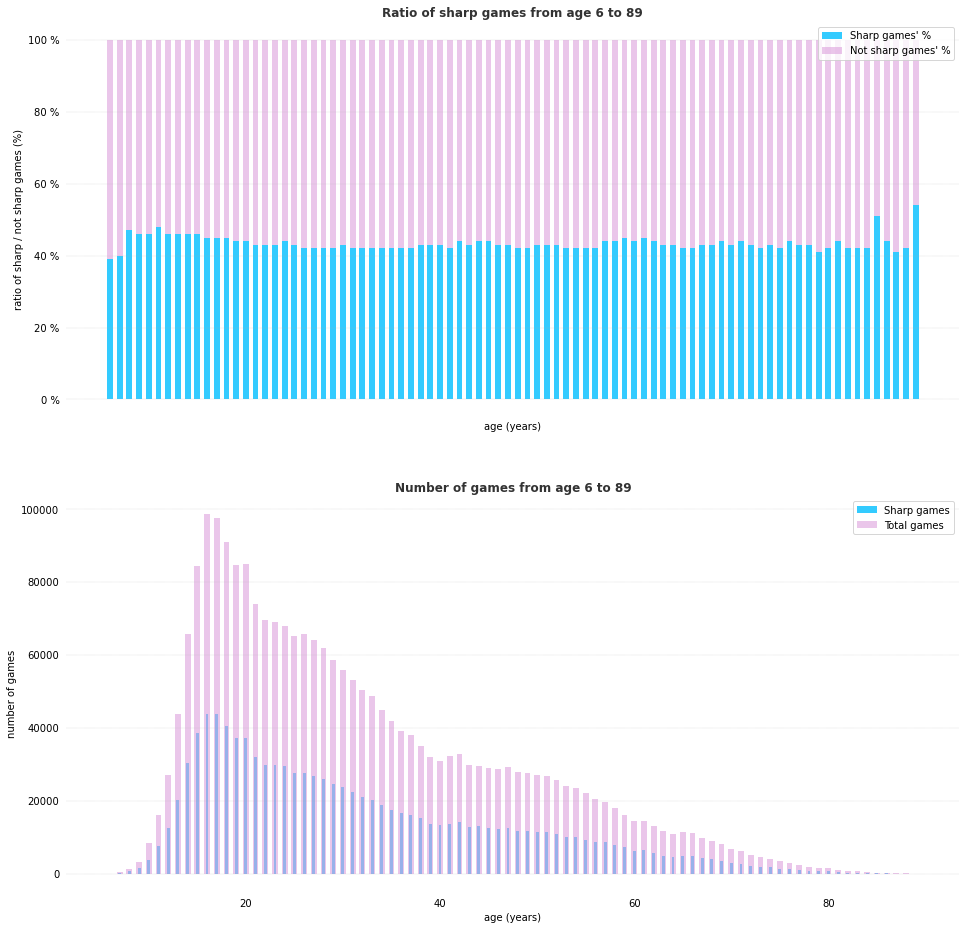

In [24]:
display_age_group_charts()

## Objective 2 Show if there are geographical patterns whether a given country's chess players select sharp or positional openings more (i.e. 'Russian school of chess')

### Explanation of Results

The goal was to show if there are geographical patters for players of a given country to have a tendency to generally play sharper openings or rather stick to positional ones. Unlike the age group data, country aggregation shows bigger differences, the highest and lowest ratios are **59% and 32%** so people in a some countries lean towards more to one of the extreme values. This means that for **some countries** the answer to the original question seems to be yes.

Looking deeper into the data, however, we should be cautious of generalising the results. Countries in the top 10 and in the bottom 10 do have quite a low number of played games, somewhere between few hundred to a few thousands, Vietnam being a notable exception. Even if data covers only mainly 10-12 years these numbers are very low, so a few players' individual style can really significantly affect this. This may not be a problem, as local schools tend to build around strong local players who teach pupils, and these pupils will naturally tend to have their trainers' style. 

These countries do not have major successes in chess (i.e. being among the top teams in the Olympiads), but usually have a few strong players. For instance Zimbabwe has 4 International masters though 3 of them were born after 1982 or Burundi has 1 Fide master. It is also obvious that these countries have much less players than the larger or more successful ones. For example Zimbabwe has 1159 players on the international list, while Burundi only 55. For comparison, Hungary has 11373 and England 9796. The outcome is there are 'schools' for countries with small number of chess players but not for large ones. Below are recommendations on improvements on this topic

### Visualisation
Below are displays of top 10 countries for playing the most and least sharp openings, as well as an overall geographical display of all countries

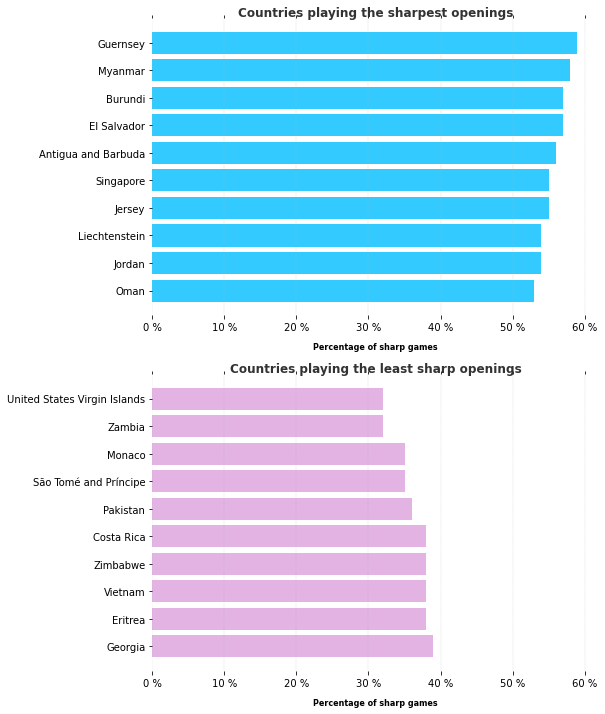

In [25]:
display_top_countries_chart()

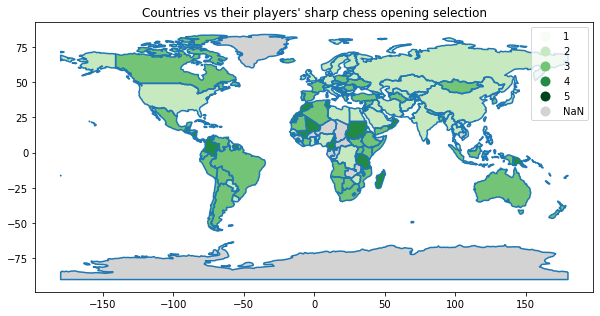

In [26]:
display_countries_classification()

# Conclusion (5 marks)

### Acheivements
Unlike the original assumption we had managed to prove the opposite, players do not change their opening style as they age. People with limited time and effort will not fall back to playing more positionally to make up for the lack of training and learning, they will leave the competitive game. It can also be seen that players who don't leave the game until 40 are more likely to stick with it for quite some more time, up to roughly 55. Between the age of 18 and 35 the number of played games halves. While general opinion is that chess is the 'old men's sport' data shows otherwise, on a competitive level it's mostly played by youth and young adults

We had also shown that there are 'country schools' in chess, but not in the original meaning of having large and broad schools in successful countries releasing players with similar opening styles. On the contrary, small countries with low number of competitive players but with one or a few stronger ones have a more distinct opening style. We conjecture that this is because strong local players teach students and their teaching is based on their style where they have the most expertise.

### Limitations

There were several smaller and larger limitations encountered during the analysis, these are:
- The available games were limited to free databases and hence we had limited data on games played before 2010. Larger, more sophisticated database, i.e.Chessbase database would have added even more depth, especially with regards to older games. 
- ECO codes assessment was done manually and is subjective . Some variations were excluded
- FIDE itself does not maintain its ID list in a perfect condition, i.e. reuses old IDs. This obviously leads to data quality issues and while it's obvious to remove people playing games at the age of -40 it's not easy to pick the more subtle ones.
- Geopandas also has some limitations. Its dataset does not include some countries that would have been important here (Jersey, Guernsey being notable examples)


### Future Work

In the future it would make sense to extend the analysis to include a magnitude more older games, run some correlation analysis between the number of countries' competitive players and their opening style and try to prove the above conjecture. It could also help if the ECO code list is revisited and probably narrowed down. Picking a few sharper lines (i.e. sampling rather than catch-all) may help deviating from the very narrow range we found here. It would be interesting to see how online and over the board games differ. 
